# Model Training Pipeline

Training models using the engineered features from Sprint 2 (02_Feature_Engineering.ipynb)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Engineered Features

Loading the features created in `02_Feature_Engineering.ipynb`

In [4]:
X_train_full = pd.read_csv('output/train_features_engineered.csv')
y_train_full = pd.read_csv('output/train_target.csv').squeeze()
X_test = pd.read_csv('output/test_features_engineered.csv')

print(f"  Training features: {X_train_full.shape}")
print(f"  Training target: {y_train_full.shape}")
print(f"  Test features: {X_test.shape}")
print(f"\n  Features: {X_train_full.shape[1]}")
print(f"  Training samples: {X_train_full.shape[0]:,}")
print(f"  Test samples: {X_test.shape[0]:,}")

  Training features: (100820, 45)
  Training target: (100820,)
  Test features: (44726, 46)

  Features: 45
  Training samples: 100,820
  Test samples: 44,726


## 2. Train/Validation Split

In [5]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print("Data split:")
print(f"  Training: {X_train.shape[0]:,} samples")
print(f"  Validation: {X_val.shape[0]:,} samples")
print(f"  Test: {X_test.shape[0]:,} samples")

Data split:
  Training: 80,656 samples
  Validation: 20,164 samples
  Test: 44,726 samples


## 3. Preprocess Features

In [6]:
# Handle categorical features
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
if categorical_features:
    print(f"  Categorical: {categorical_features}")

# Create preprocessor
transformers = []
if numeric_features:
    transformers.append(('scaler', StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features))

if transformers:
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    
    # Fit and transform
    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    X_test_proc = preprocessor.transform(X_test)
    
    print(f"\n✓ Preprocessing complete")
    print(f"  Final feature count: {X_train_proc.shape[1]}")
else:
    X_train_proc = X_train.values
    X_val_proc = X_val.values
    X_test_proc = X_test.values
    print("\n✓ No preprocessing needed")

Numeric features: 41
Categorical features: 3
  Categorical: ['performance_category', 'time_category', 'lexicon_category']

✓ Preprocessing complete
  Final feature count: 52


## 4. Train Models

### 4.1 Random Forest

In [7]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf.fit(X_train_proc, y_train)

# Evaluate
y_pred_train = rf.predict(X_train_proc)
y_pred_val = rf.predict(X_val_proc)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)
val_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")
print(f"  MAPE: {train_mape:.2f}%")
print(f"  R²:   {train_r2:.4f}")

print(f"\nValidation Metrics:")
print(f"  RMSE: {val_rmse:.2f}")
print(f"  MAE:  {val_mae:.2f}")
print(f"  MAPE: {val_mape:.2f}%")
print(f"  R²:   {val_r2:.4f}")

rf_results = {'model': 'RandomForest', 'train_rmse': train_rmse, 'train_r2': train_r2,
              'val_rmse': val_rmse, 'val_r2': val_r2, 'val_mape': val_mape}


Training Metrics:
  RMSE: 56.29
  MAE:  37.93
  MAPE: 2.02%
  R²:   0.9411

Validation Metrics:
  RMSE: 92.75
  MAE:  62.11
  MAPE: 3.35%
  R²:   0.8394


### 4.2 XGBoost

In [8]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train_proc, y_train)

# Evaluate
y_pred_train = xgb_model.predict(X_train_proc)
y_pred_val = xgb_model.predict(X_val_proc)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
val_mae = mean_absolute_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)
val_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  MAE:  {train_mae:.2f}")
print(f"  MAPE: {train_mape:.2f}%")
print(f"  R²:   {train_r2:.4f}")

print(f"\nValidation Metrics:")
print(f"  RMSE: {val_rmse:.2f}")
print(f"  MAE:  {val_mae:.2f}")
print(f"  MAPE: {val_mape:.2f}%")
print(f"  R²:   {val_r2:.4f}")

xgb_results = {'model': 'XGBoost', 'train_rmse': train_rmse, 'train_r2': train_r2,
               'val_rmse': val_rmse, 'val_r2': val_r2, 'val_mape': val_mape}


Training Metrics:
  RMSE: 94.55
  MAE:  67.19
  MAPE: 3.63%
  R²:   0.8337

Validation Metrics:
  RMSE: 98.22
  MAE:  68.99
  MAPE: 3.73%
  R²:   0.8199


## 5. Model Comparison

In [9]:
# Compare models
comparison_df = pd.DataFrame([rf_results, xgb_results])
comparison_df = comparison_df.sort_values('val_rmse')

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('output/model_comparison.csv', index=False)
print("\n✓ Comparison saved to output/model_comparison.csv")


MODEL COMPARISON
       model  train_rmse  train_r2  val_rmse   val_r2  val_mape
RandomForest   56.294559  0.941060 92.752554 0.839373  3.348225
     XGBoost   94.553856  0.833721 98.224735 0.819860  3.731680

✓ Comparison saved to output/model_comparison.csv


## 6. Visualize Performance

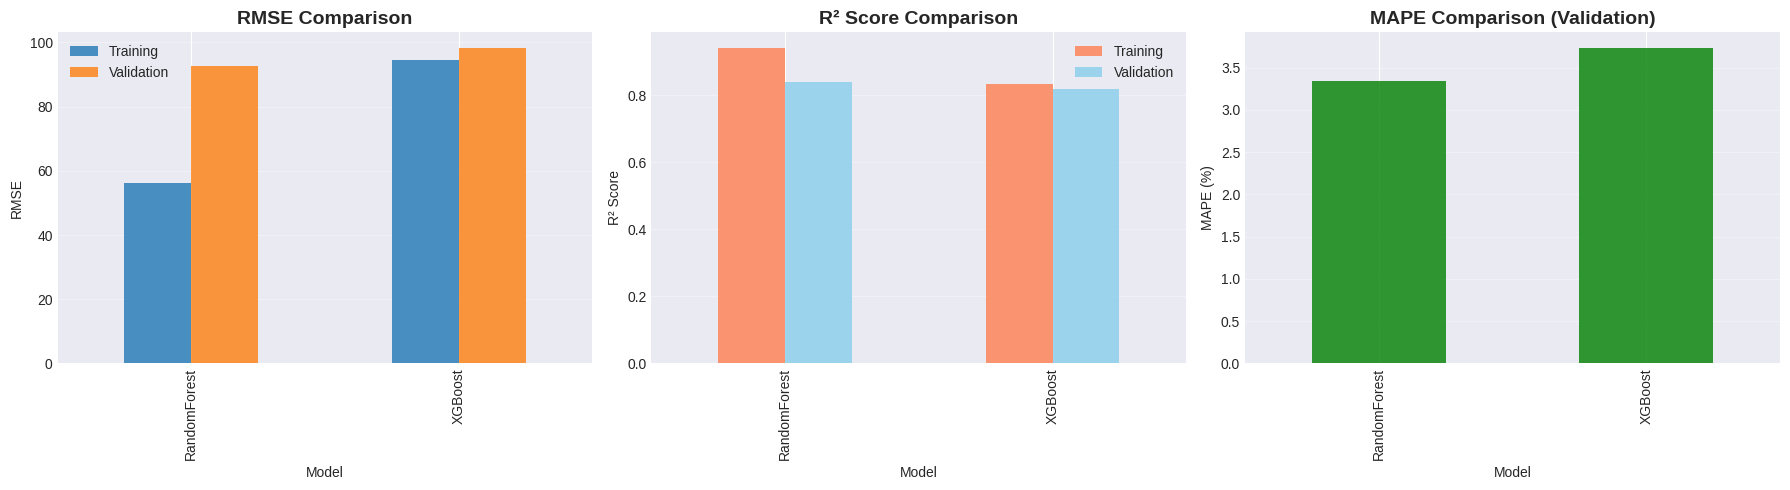

✓ Plot saved to output/model_comparison.png


In [10]:
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
comparison_df.plot(x='model', y=['train_rmse', 'val_rmse'], kind='bar', ax=axes[0], alpha=0.8)
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].legend(['Training', 'Validation'])
axes[0].grid(True, alpha=0.3, axis='y')

# R²
comparison_df.plot(x='model', y=['train_r2', 'val_r2'], kind='bar', ax=axes[1], alpha=0.8, color=['coral', 'skyblue'])
axes[1].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('R² Score')
axes[1].set_xlabel('Model')
axes[1].legend(['Training', 'Validation'])
axes[1].grid(True, alpha=0.3, axis='y')

# MAPE
comparison_df.plot(x='model', y='val_mape', kind='bar', ax=axes[2], alpha=0.8, color='green', legend=False)
axes[2].set_title('MAPE Comparison (Validation)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAPE (%)')
axes[2].set_xlabel('Model')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('output/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to output/model_comparison.png")

## 7. Feature Importance


Top 20 Features (Average Importance):
   feature  rf_importance  xgb_importance  avg_importance
feature_48       0.278122        0.511858        0.394990
feature_49       0.199635        0.175797        0.187716
feature_11       0.047926        0.064641        0.056283
feature_27       0.072780        0.012260        0.042520
feature_16       0.042146        0.041110        0.041628
feature_32       0.023618        0.056937        0.040277
feature_39       0.047048        0.010971        0.029009
feature_51       0.051261        0.000000        0.025631
feature_31       0.025121        0.026011        0.025566
feature_25       0.029164        0.006821        0.017992
 feature_2       0.028861        0.006459        0.017660
 feature_7       0.029004        0.004127        0.016566
feature_38       0.018821        0.002197        0.010509
 feature_1       0.013224        0.000876        0.007050
 feature_9       0.006043        0.007157        0.006600
feature_17       0.007077        

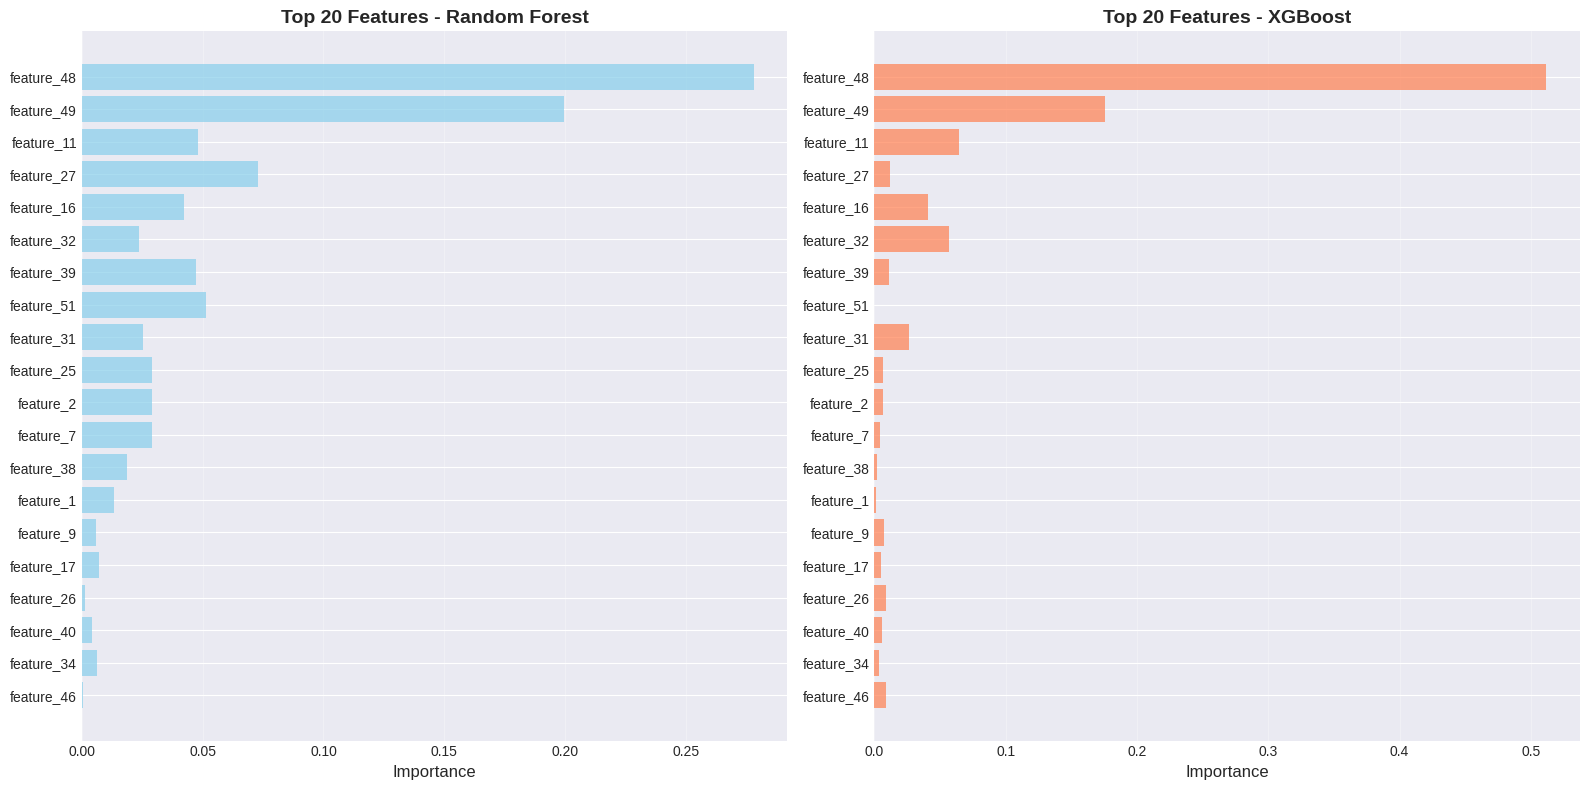


✓ Feature importance plots saved


In [11]:
# Random Forest Feature Importance
if hasattr(rf, 'feature_importances_'):
    try:
        feature_names = []
        if 'scaler' in preprocessor.named_transformers_:
            feature_names.extend(numeric_features)
        if 'encoder' in preprocessor.named_transformers_:
            ohe = preprocessor.named_transformers_['encoder']
            cat_names = ohe.get_feature_names_out(categorical_features).tolist()
            feature_names.extend(cat_names)
        
        if len(feature_names) != len(rf.feature_importances_):
            feature_names = [f'feature_{i}' for i in range(len(rf.feature_importances_))]
    except:
        feature_names = [f'feature_{i}' for i in range(len(rf.feature_importances_))]
    
    rf_importance = pd.DataFrame({
        'feature': feature_names,
        'rf_importance': rf.feature_importances_
    })

# XGBoost Feature Importance
if hasattr(xgb_model, 'feature_importances_'):
    xgb_importance = pd.DataFrame({
        'feature': feature_names,
        'xgb_importance': xgb_model.feature_importances_
    })

# Merge and compare
importance_df = rf_importance.merge(xgb_importance, on='feature')
importance_df['avg_importance'] = (importance_df['rf_importance'] + importance_df['xgb_importance']) / 2
importance_df = importance_df.sort_values('avg_importance', ascending=False)

print(f"\nTop 20 Features (Average Importance):")
print(importance_df.head(20)[['feature', 'rf_importance', 'xgb_importance', 'avg_importance']].to_string(index=False))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_20 = importance_df.head(20)
axes[0].barh(top_20['feature'][::-1], top_20['rf_importance'][::-1], alpha=0.7, color='skyblue')
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Top 20 Features - Random Forest', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(top_20['feature'][::-1], top_20['xgb_importance'][::-1], alpha=0.7, color='coral')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Top 20 Features - XGBoost', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('output/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plots saved")

## 8. Generate Predictions with Best Model

In [12]:
# Select best model
best_model_name = comparison_df.iloc[0]['model']
print(f"Best model: {best_model_name}")
print(f"Validation RMSE: {comparison_df.iloc[0]['val_rmse']:.2f}")
print(f"Validation MAPE: {comparison_df.iloc[0]['val_mape']:.2f}%")
print(f"Validation R²: {comparison_df.iloc[0]['val_r2']:.4f}")

# Get the best model
if best_model_name == 'RandomForest':
    best_model = rf
else:
    best_model = xgb_model

# Generate predictions
print("\nGenerating predictions on test set...")
test_predictions = best_model.predict(X_test_proc)

print(f"\n✓ Generated {len(test_predictions)} predictions")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std: {test_predictions.std():.2f}")
print(f"  Min: {test_predictions.min():.2f}")
print(f"  Max: {test_predictions.max():.2f}")

Best model: RandomForest
Validation RMSE: 92.75
Validation MAPE: 3.35%
Validation R²: 0.8394

Generating predictions on test set...

✓ Generated 44726 predictions
  Mean: 1918.02
  Std: 178.26
  Min: 1167.65
  Max: 2289.00


## 9. Save Results

In [13]:
# Save predictions
predictions_df = pd.DataFrame({'rating': test_predictions})
predictions_df.to_csv('output/predictions.csv', index=False)
print("✓ Predictions saved to output/predictions.csv")

# Save best model
import joblib
model_path = f'output/best_model_{best_model_name.lower()}.pkl'
joblib.dump(best_model, model_path)
print(f"✓ Best model saved to {model_path}")

✓ Predictions saved to output/predictions.csv
✓ Best model saved to output/best_model_randomforest.pkl


## 10. Summary

In [14]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print(f"\n📊 Models Trained: 2")
print(f"   • Random Forest")
print(f"   • XGBoost")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   • Validation RMSE: {comparison_df.iloc[0]['val_rmse']:.2f}")
print(f"   • Validation MAPE: {comparison_df.iloc[0]['val_mape']:.2f}%")
print(f"   • Validation R²: {comparison_df.iloc[0]['val_r2']:.4f}")

print(f"\n📁 Output Files:")
print(f"   • output/model_comparison.csv")
print(f"   • output/model_comparison.png")
print(f"   • output/feature_importance.png")
print(f"   • output/predictions.csv")
print(f"   • output/best_model_{best_model_name.lower()}.pkl")

print(f"\n✅ Training complete!")
print("="*60)


TRAINING SUMMARY

📊 Models Trained: 2
   • Random Forest
   • XGBoost

🏆 Best Model: RandomForest
   • Validation RMSE: 92.75
   • Validation MAPE: 3.35%
   • Validation R²: 0.8394

📁 Output Files:
   • output/model_comparison.csv
   • output/model_comparison.png
   • output/feature_importance.png
   • output/predictions.csv
   • output/best_model_randomforest.pkl

✅ Training complete!
